# Sto learning 


In [1]:
import matplotlib.pyplot as plt
import dgl
from torch.utils.data import DataLoader
import torch
import time
import os
import sys
sys.path.insert(0, "../lib/")
import laplacian
import ninja
import sys
import utils
import model
import graphs
from utils import set_device
from laplacian import normalized_laplacian


# Autoreload
%load_ext autoreload
%autoreload 2

# GPU
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

device = set_device(verbose=True)

cuda available


# MNIST

In [2]:
# Downloads the dataset if not found locally
from mnist import check_mnist_dataset_exists, datasampler, MNISTDataset, MNIST_rand

_ = check_mnist_dataset_exists()

nb_selected_train_data = 55000
nb_selected_test_data = 10000

train_data, train_labels, test_data, test_labels, val_data, val_labels= datasampler(
    nb_selected_train_data, nb_selected_test_data
)

trainset = MNIST_rand(train_data, train_labels, removal_rate=0.25)
valset = MNIST_rand(val_data, val_labels)
testset = MNIST_rand(test_data, test_labels)

## Visualise the dataset

Label: tensor(5.)
graph: DGLGraph(num_nodes=784, num_edges=2806,
         ndata_schemes={}
         edata_schemes={})
Largest eigenvalue: 2.0
Smallest eigenvalue: -2.1584296849841422e-15


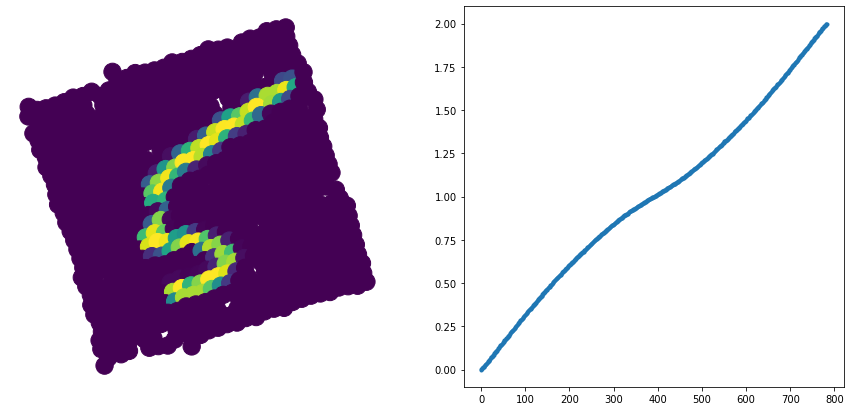

In [3]:
import networkx as nx
import random
from ninja import GeigplotL
plt.figure(figsize=(15,7))

plt.subplot(121)
g_demo, l_demo , s_demo= valset[random.randrange(5000)]
nx.draw_kamada_kawai(g_demo.to_networkx().to_undirected(),node_color=s_demo)
print('Label:',l_demo)
print('graph:',g_demo)

plt.subplot(122)
GeigplotL(g_demo)
plt.show()



# Model definition for training

In [4]:
from model import DGL_mean_Classifier, Classifier, DGL_global_pooling_Classifier
# model_parameters
in_features = 1
first_conv_out = 64
second_conv_out = 128
hidden_layer_classifier = 250
k = 5
n_classes = 10

net = DGL_mean_Classifier(
    in_features, 
    first_conv_out, 
    second_conv_out, 
    hidden_layer_classifier, 
    n_classes, 
    k,
    readout="max"
)

print(net)
if torch.cuda.is_available():
    net.to(device)

DGL_mean_Classifier(
  (layers): ModuleList(
    (0): ChebConv(
      (fc): ModuleList(
        (0): Linear(in_features=1, out_features=64, bias=False)
        (1): Linear(in_features=1, out_features=64, bias=False)
        (2): Linear(in_features=1, out_features=64, bias=False)
        (3): Linear(in_features=1, out_features=64, bias=False)
        (4): Linear(in_features=1, out_features=64, bias=False)
      )
    )
    (1): ChebConv(
      (fc): ModuleList(
        (0): Linear(in_features=64, out_features=128, bias=False)
        (1): Linear(in_features=64, out_features=128, bias=False)
        (2): Linear(in_features=64, out_features=128, bias=False)
        (3): Linear(in_features=64, out_features=128, bias=False)
        (4): Linear(in_features=64, out_features=128, bias=False)
      )
    )
    (2): ChebConv(
      (fc): ModuleList(
        (0): Linear(in_features=128, out_features=256, bias=False)
        (1): Linear(in_features=128, out_features=256, bias=False)
        (2): L

In [5]:
from utils import load_model
net.load_state_dict(load_model('Cheb_max_orig_cone'))

<All keys matched successfully>

# Training pipe

In [6]:
import torch.optim as optim
import torch.nn as nn
#
from utils import collate, collate2
#

train_loader = DataLoader(trainset, batch_size=50,
                         shuffle=True, collate_fn=collate, drop_last=True, pin_memory=False)
val_loader =  DataLoader(valset, batch_size=300,
                         shuffle=False, collate_fn=collate, drop_last=True, pin_memory=False)
test_loader =  DataLoader(testset, batch_size=300,
                         shuffle=False, collate_fn=collate, drop_last=True, pin_memory=False)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.99)

epoch_losses = []

In [7]:
def train(model, device, data_loader, epochs, loss_func, optimizer, scheduler):

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        t0 = time.time()

        for iter, (data, label, signal) in enumerate(data_loader):
            data, label, signal = data.to(device), label.to(device), signal.to(device)

            output = model(data, 
                           signal.float().view(-1, 1).to(device),
                           (torch.ones(200)*2).to(device))
            loss = loss_func(output, label.long().to(device))

            # sum up batch loss
            epoch_loss += loss.detach().item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(label.view_as(pred)).sum().item()

        epoch_loss /= iter + 1
        
        val_loss = test(net, device, val_loader, False)

        scheduler.step()

        print(
            "Epoch {} loss - train {:.4f} - val {:.4f} - Acc: {} ({:.1f}%) in {:.1f}s".format(
                epoch, epoch_loss, val_loss, correct,
            100 * correct / len(data_loader.dataset), time.time() - t0
            )
        )
        epoch_losses.append([epoch_loss, val_loss])

In [8]:
def test(model, device, data_loader, verbose=True):
    model.eval()
    test_loss = 0
    correct = 0
    tot_label = []
    tot_pred = []

    with torch.no_grad():
        for iter, (data, label, signal) in enumerate(data_loader):
            
            data, label, signal = data.to(device), label.to(device), signal.to(device)

            output = model(data, signal.view(-1, 1).float(), (torch.ones(300)*2).to(device))
            if verbose and iter == 0:
                #print(output[0:5], output.size())
            # sum up batch loss
            test_loss += loss_func(output, label.long().to(device)).item()

            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(label.view_as(pred)).sum().item()

            tot_label.append(label.cpu())
            tot_pred.append(pred.cpu())

    # for the classification report
    tot_label = torch.stack(tot_label).view(-1).cpu()
    tot_pred = torch.stack(tot_pred).view(-1).cpu()

    test_loss /= iter + 1

    if verbose:
        print('\n Average loss per epoch: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

        # BATCHED DGL EXAMPLE
        import sklearn
        from sklearn.metrics import classification_report

        print(sklearn.metrics.classification_report(tot_label, tot_pred))

    else:
        return test_loss

## Training time

In [9]:
test(net,device,test_loader)
torch.cuda.empty_cache()

tensor([[ -7.9585,  -8.8606,   1.9711,  -6.2843,  -3.1102,   3.4253,  -5.2768,
          10.5983,  -9.6045, -11.1650],
        [-10.1767, -36.7124,  17.6854,   9.6884, -20.0864,  10.2548,  -2.1412,
         -13.5540,  -2.7951, -12.5471],
        [-35.3296,  29.8117, -15.6798, -22.2595,  -0.3158, -22.5077, -29.8163,
          -4.1164, -18.9095,  -8.9710],
        [ 20.3071, -44.5002,   0.6446,  -9.7290,  -8.3469,   5.6389,   5.0596,
         -21.8757,  -5.0074,  -0.2079],
        [ -7.1332, -10.8592,   6.1611,   1.0099,   1.8421,   2.6808,  -6.9647,
          -2.2035,  -6.4198,  -6.3309]], device='cuda:0') torch.Size([300, 10])

 Average loss per epoch: 5.5219, Accuracy: 5587/10000 (56%)

              precision    recall  f1-score   support

         0.0       0.88      0.81      0.84       969
         1.0       0.99      0.57      0.73      1123
         2.0       0.45      0.72      0.55      1023
         3.0       0.51      0.80      0.62      1000
         4.0       0.94      0.2

In [10]:
train(net, device, train_loader, 20, loss_func,optimizer, scheduler)

Epoch 0 loss - train 1.0573 - val 0.4541 - Acc: 36353 (66.1%) in 1456.8s
Epoch 1 loss - train 0.8003 - val 0.4710 - Acc: 40132 (73.0%) in 1466.8s
Epoch 2 loss - train 0.7558 - val 0.4004 - Acc: 41060 (74.7%) in 1457.0s
Epoch 3 loss - train 0.7139 - val 0.3964 - Acc: 41688 (75.8%) in 1428.3s
Epoch 4 loss - train 0.6981 - val 0.4391 - Acc: 41991 (76.3%) in 1467.3s
Epoch 5 loss - train 0.6799 - val 0.3522 - Acc: 42296 (76.9%) in 1481.7s
Epoch 6 loss - train 0.6713 - val 0.3365 - Acc: 42543 (77.4%) in 1477.1s
Epoch 7 loss - train 0.6610 - val 0.3447 - Acc: 42705 (77.6%) in 1417.8s
Epoch 8 loss - train 0.6464 - val 0.3351 - Acc: 43034 (78.2%) in 1379.0s
Epoch 9 loss - train 0.6400 - val 0.3164 - Acc: 42971 (78.1%) in 1374.9s
Epoch 10 loss - train 0.6340 - val 0.3298 - Acc: 43202 (78.5%) in 1369.0s
Epoch 11 loss - train 0.6195 - val 0.3335 - Acc: 43551 (79.2%) in 1377.9s
Epoch 12 loss - train 0.6180 - val 0.3021 - Acc: 43491 (79.1%) in 1385.6s
Epoch 13 loss - train 0.6032 - val 0.3417 - Acc:

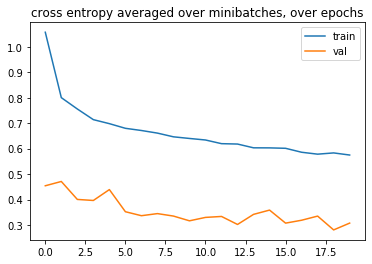

In [15]:
plt.title("cross entropy averaged over minibatches, over epochs")
plt.plot(epoch_losses)
plt.legend(['train','val'])
plt.show()

In [12]:
torch.cuda.empty_cache()

## Test Metrics

In [ ]:
test(net,device,test_loader)

tensor([[-11.7297,  -3.2538,  -0.7460,  -4.7361,  -3.2054,   1.1484,  -3.3100,
           7.9614,  -6.2744,  -5.2267],
        [ -7.2486,  -9.3409,   3.4708,   3.3333,  -3.9547,   3.2142,  -4.8333,
          -5.1108,  -5.5948,  -2.6325],
        [-31.4942,   9.3282, -14.4915, -12.5633,  -8.0434, -10.0590, -25.0594,
         -11.6905, -11.7301, -15.8869],
        [  6.7389, -18.2171,  -3.8343,  -5.6692,  -4.5254,  -6.1571,  -1.1131,
          -4.3174,  -2.2298,   5.1592],
        [ -8.6932,  -5.6552,   0.6474,  -6.0387,   7.1009,  -2.5298,  -9.4673,
          -0.7545,  -6.1115,   3.4555]], device='cuda:0') torch.Size([300, 10])


## Saving

In [ ]:
from utils import save_model

save_model("Cheb_max_rand_orig", net)